## Setting Up:

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [4]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

# Drop Nan entries in hugonnetdhdt of Iceland dataset
data_wgms = data_wgms.dropna(subset=data_wgms.columns.drop('DATA_MODIFICATION'))

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns


Number of glaciers: 47
Number of winter, summer and annual samples: 5930
Number of annual samples: 2883
Number of winter samples: 3047
Number of summer samples: 0


Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

## B. Progressive Transfer

In [5]:
data_ICE_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'ICE_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-07-31 15:22:35,268 - INFO - Loaded preprocessed data.
2025-07-31 15:22:35,268 - INFO - Number of monthly rows: 56209
2025-07-31 15:22:35,276 - INFO - Number of annual samples: 34915
2025-07-31 15:22:35,281 - INFO - Number of winter samples: 21294


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-4.787933,0.003747,198886.0,590722.0,3990646.0,0.84564,-1779436.0,-0.590102,0.603381
1,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-5.262054,0.003766,306376.0,576896.0,883468.0,0.84690,-1458576.0,0.129348,2.214950


In [6]:
display(data_monthly['GLACIER'].value_counts())
display(data_monthly.shape)

display()

GLACIER
RGI60-06.00238                                8230
Bruarjoekull                                  6814
Skeidararjoekull                              5008
Thjorsarjoekull (Hofsjoekull E)               3962
Blagnipujoekull (Hofsjoekull SW)              3317
Hagafellsjoekull West                         3207
Breidamerkurjoekull                           2953
Koeldukvislarjoekull                          2897
Langjoekull Ice Cap                           2647
Dyngjujoekull                                 2305
Eyjabakkajoekull                              2110
Tungnaarjoekull                               1430
Hagafellsjoekull East (Langjoekull S Dome)    1050
RGI60-06.00292                                1001
RGI60-06.00302                                 973
RGI60-06.00478                                 957
RGI60-06.00294                                 946
RGI60-06.00311                                 857
RGI60-06.00465                                 741
Mulajoekull            

(56209, 28)

In [7]:
display(data_monthly[data_monthly['GLACIER']=='RGI60-06.00478'])

,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
11313,2012.0,-16.083328,64.299924,2.0565,1109.591877,173.031764,1282.623641,RGI60-06.00478,RGI60-06.00478_2012.0_annual_Skf01c,934,...,28.029856,-3.040863,0.011360,48308.0,505668.0,829892.0,0.849998,-1216018.0,0.219022,0.383545
11314,2012.0,-16.083328,64.299924,2.0565,1109.591877,173.031764,1282.623641,RGI60-06.00478,RGI60-06.00478_2012.0_annual_Skf01c,934,...,28.029856,-11.800385,0.004218,162724.0,1206426.0,211552.0,0.849999,-1712452.0,1.401711,-1.734920
11315,2012.0,-16.083328,64.299924,2.0565,1109.591877,173.031764,1282.623641,RGI60-06.00478,RGI60-06.00478_2012.0_annual_Skf01c,934,...,28.029856,-7.321381,0.010261,101626.0,954686.0,545492.0,0.849994,-1633885.0,1.353951,0.174945
11316,2012.0,-16.083328,64.299924,2.0565,1109.591877,173.031764,1282.623641,RGI60-06.00478,RGI60-06.00478_2012.0_annual_Skf01c,934,...,28.029856,-4.628021,0.008603,4704.0,931571.0,2805798.0,0.850006,-2152305.0,1.821436,1.046079
11317,2012.0,-16.083328,64.299924,2.0565,1109.591877,173.031764,1282.623641,RGI60-06.00478,RGI60-06.00478_2012.0_annual_Skf01c,934,...,28.029856,-3.636322,0.008985,25344.0,811247.0,7613135.0,0.850000,-2212118.0,1.521696,1.570902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49476,2023.0,-16.083715,64.300288,2.7610,1109.591877,173.768123,1283.360000,RGI60-06.00478,RGI60-06.00478_2023.0_winter_Skf01,4961,...,25.492832,-12.362640,0.001199,21814.0,705037.0,102896.0,0.849999,-1249884.0,0.846244,-3.484245
49477,2023.0,-16.083715,64.300288,2.7610,1109.591877,173.768123,1283.360000,RGI60-06.00478,RGI60-06.00478_2023.0_winter_Skf01,4961,...,25.492832,-8.772797,0.003320,82780.0,550359.0,275574.0,0.849994,-893011.0,1.304887,-1.397207
49478,2023.0,-16.083715,64.300288,2.7610,1109.591877,173.768123,1283.360000,RGI60-06.00478,RGI60-06.00478_2023.0_winter_Skf01,4961,...,25.492832,-6.058197,0.004551,66169.0,434712.0,1287500.0,0.850001,-924680.0,1.655766,1.135592
49479,2023.0,-16.083715,64.300288,2.7610,1109.591877,173.768123,1283.360000,RGI60-06.00478,RGI60-06.00478_2023.0_winter_Skf01,4961,...,25.492832,-11.549896,0.002980,9640.0,631656.0,4019275.5,0.849996,-1499974.5,0.300636,-3.202634


###### 4 glaciers 50% train set

In [ ]:
# TRANSFER LEARNING SETUP 50%
# Fine-tuning glaciers (4 Iceland glaciers to adapt Swiss model)
train_glaciers = ['Bruarjoekull', 'Skeidararjoekull', 'Koeldukvislarjoekull', 'Slettjoekull West', 'RGI60-06.00238', 'Hagafellsjoekull West']

# Test glaciers (all remaining Iceland glaciers)
all_iceland_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_iceland_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))


Fine-tuning glaciers (6): ['Bruarjoekull', 'Skeidararjoekull', 'Koeldukvislarjoekull', 'Slettjoekull West', 'RGI60-06.00238', 'Hagafellsjoekull West']
Test glaciers (41): ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328', 'Tungnaarjoekull', 'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Oeldufellsjoekull', 'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340', 'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00320', 'Hagafellsjoekull East (Langjoekull S Dome)', 'RGI60-06.00342', 'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00232', 'RGI60-06.00478', 'Mulajoekull', 'RGI60-06.00301', 'RGI60-06.00413', 'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228', 'RGI60-06.00409', 'RGI60-06.00349', 'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00425', 'RGI60-06.00306', 'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00445', 'RGI60-06.00474']
Train glaciers:

'length train set'

26443

'length test set'

29766

###### Split east/west

In [6]:
# Get glacier latitudes
glacier_lat = data_wgms.groupby('GLACIER')['POINT_LON'].first()

# Use the median latitude as the split
lon_threshold = -18.25

east_glaciers = glacier_lat[glacier_lat >= lon_threshold].index.tolist()
west_glaciers = glacier_lat[glacier_lat < lon_threshold].index.tolist()

print(f"East glaciers ({len(east_glaciers)}): {east_glaciers}")
print(f"West glaciers ({len(west_glaciers)}): {west_glaciers}")

East glaciers (20): ['Breidamerkurjoekull', 'Bruarjoekull', 'Dyngjujoekull', 'Eyjabakkajoekull', 'Koeldukvislarjoekull', 'RGI60-06.00409', 'RGI60-06.00411', 'RGI60-06.00413', 'RGI60-06.00422', 'RGI60-06.00425', 'RGI60-06.00445', 'RGI60-06.00465', 'RGI60-06.00466', 'RGI60-06.00474', 'RGI60-06.00476', 'RGI60-06.00478', 'RGI60-06.00479', 'RGI60-06.00480', 'Skeidararjoekull', 'Tungnaarjoekull']
West glaciers (27): ['Blagnipujoekull (Hofsjoekull SW)', 'Hagafellsjoekull East (Langjoekull S Dome)', 'Hagafellsjoekull West', 'Langjoekull Ice Cap', 'Mulajoekull', 'Oeldufellsjoekull', 'RGI60-06.00228', 'RGI60-06.00232', 'RGI60-06.00238', 'RGI60-06.00292', 'RGI60-06.00294', 'RGI60-06.00296', 'RGI60-06.00301', 'RGI60-06.00302', 'RGI60-06.00303', 'RGI60-06.00305', 'RGI60-06.00306', 'RGI60-06.00311', 'RGI60-06.00320', 'RGI60-06.00328', 'RGI60-06.00340', 'RGI60-06.00342', 'RGI60-06.00349', 'RGI60-06.00350', 'RGI60-06.00359', 'Slettjoekull West', 'Thjorsarjoekull (Hofsjoekull E)']


In [7]:
# North/south at median, train is south set 50%
train_glaciers = east_glaciers

# Test glaciers (all remaining Iceland glaciers)
all_iceland_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_iceland_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))

Fine-tuning glaciers (20): ['Breidamerkurjoekull', 'Bruarjoekull', 'Dyngjujoekull', 'Eyjabakkajoekull', 'Koeldukvislarjoekull', 'RGI60-06.00409', 'RGI60-06.00411', 'RGI60-06.00413', 'RGI60-06.00422', 'RGI60-06.00425', 'RGI60-06.00445', 'RGI60-06.00465', 'RGI60-06.00466', 'RGI60-06.00474', 'RGI60-06.00476', 'RGI60-06.00478', 'RGI60-06.00479', 'RGI60-06.00480', 'Skeidararjoekull', 'Tungnaarjoekull']
Test glaciers (27): ['Thjorsarjoekull (Hofsjoekull E)', 'RGI60-06.00328', 'Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Oeldufellsjoekull', 'Slettjoekull West', 'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340', 'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00238', 'RGI60-06.00320', 'Hagafellsjoekull East (Langjoekull S Dome)', 'RGI60-06.00342', 'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00232', 'Mulajoekull', 'RGI60-06.00301', 'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00228', 'RGI60-06.00349', 'RGI60-06.00305', 'RGI60-06.00306', 'RGI60-06.00296']
Train glaciers

'length train set'

26777

'length test set'

29432

###### 5-10% train set

In [ ]:
# TRANSFER LEARNING SETUP 5-10%
# Fine-tuning glaciers
train_glaciers = ['Mulajoekull' ,'Slettjoekull West', 'Hagafellsjoekull East (Langjoekull S Dome)', 'Tungnaarjoekull', 'RGI60-06.00478']

# Test glaciers (all remaining Iceland glaciers)
all_iceland_glaciers = list(data_wgms['GLACIER'].unique())
test_glaciers = [g for g in all_iceland_glaciers if g not in train_glaciers]

print(f"Fine-tuning glaciers ({len(train_glaciers)}): {train_glaciers}")
print(f"Test glaciers ({len(test_glaciers)}): {test_glaciers}")

# Ensure all glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_fine_tune = [g for g in train_glaciers if g not in existing_glaciers]
missing_test = [g for g in test_glaciers if g not in existing_glaciers]

if missing_fine_tune:
    print(f"Warning: Fine-tuning glaciers not in dataset: {missing_fine_tune}")
if missing_test:
    print(f"Warning: Test glaciers not in dataset: {missing_test}")


## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

display('length train set', len(train_set['df_X']))
display('length test set', len(test_set['df_X']))

Fine-tuning glaciers (5): ['Mulajoekull', 'Slettjoekull West', 'Hagafellsjoekull East (Langjoekull S Dome)', 'Tungnaarjoekull', 'RGI60-06.00478']
Test glaciers (42): ['Thjorsarjoekull (Hofsjoekull E)', 'Breidamerkurjoekull', 'Dyngjujoekull', 'RGI60-06.00328', 'Hagafellsjoekull West', 'Eyjabakkajoekull', 'RGI60-06.00303', 'Langjoekull Ice Cap', 'Koeldukvislarjoekull', 'Oeldufellsjoekull', 'Skeidararjoekull', 'RGI60-06.00466', 'RGI60-06.00411', 'RGI60-06.00302', 'RGI60-06.00359', 'RGI60-06.00340', 'Bruarjoekull', 'Blagnipujoekull (Hofsjoekull SW)', 'RGI60-06.00238', 'RGI60-06.00320', 'RGI60-06.00342', 'RGI60-06.00480', 'RGI60-06.00465', 'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00232', 'RGI60-06.00301', 'RGI60-06.00413', 'RGI60-06.00311', 'RGI60-06.00350', 'RGI60-06.00476', 'RGI60-06.00228', 'RGI60-06.00409', 'RGI60-06.00349', 'RGI60-06.00422', 'RGI60-06.00305', 'RGI60-06.00425', 'RGI60-06.00306', 'RGI60-06.00479', 'RGI60-06.00296', 'RGI60-06.00445', 'RGI60-06.00474']
Train glaciers:

'length train set'

4393

'length test set'

51816

In [ ]:
display(test_set)
display(train_set)

{'df_X':          YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
 0      1989.0 -18.595688  64.790063           0.45       1094.738918   
 1      1989.0 -18.595688  64.790063           0.45       1094.738918   
 2      1989.0 -18.595688  64.790063           0.45       1094.738918   
 3      1989.0 -18.595688  64.790063           0.45       1094.738918   
 4      1989.0 -18.595688  64.790063           0.45       1094.738918   
 ...       ...        ...        ...            ...               ...   
 56204  2023.0 -18.843883  64.793858           1.97       1394.770027   
 56205  2023.0 -18.843883  64.793858           1.97       1394.770027   
 56206  2023.0 -18.843883  64.793858           1.97       1394.770027   
 56207  2023.0 -18.843883  64.793858           1.97       1394.770027   
 56208  2023.0 -18.843883  64.793858           1.97       1394.770027   
 
        ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
 0                -45.138918           1049.6  RG

{'df_X':          YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
 460    1992.0 -18.044974  64.330727         -1.370        985.236975   
 461    1992.0 -18.044974  64.330727         -1.370        985.236975   
 462    1992.0 -18.044974  64.330727         -1.370        985.236975   
 463    1992.0 -18.044974  64.330727         -1.370        985.236975   
 464    1992.0 -18.044974  64.330727         -1.370        985.236975   
 ...       ...        ...        ...            ...               ...   
 54371  1998.0 -20.177130  64.535620          0.704        587.898661   
 54372  1998.0 -20.177130  64.535620          0.704        587.898661   
 54373  1998.0 -20.177130  64.535620          0.704        587.898661   
 54374  1998.0 -20.177130  64.535620          0.704        587.898661   
 54375  1998.0 -20.177130  64.535620          0.704        587.898661   
 
        ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
 460               47.163025           1032.4  RG

###### Train/val split on random 80/20

In [8]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train data glacier distribution: GLACIER
Bruarjoekull            5521
Skeidararjoekull        3976
Breidamerkurjoekull     2406
Koeldukvislarjoekull    2273
Dyngjujoekull           1865
Name: count, dtype: int64
Val data glacier distribution: GLACIER
Bruarjoekull            1293
Skeidararjoekull        1032
Koeldukvislarjoekull     624
Breidamerkurjoekull      547
Eyjabakkajoekull         454
Name: count, dtype: int64
Train data shape: (21389, 29)
Val data shape: (5388, 29)


###### Train/val split on specific glacier

In [ ]:
# Glacier-wise train/val split: validate on Engabreen, train on the other 3
data_train = train_set['df_X']
data_train['y'] = train_set['y']

val_glacier = ['Engabreen']
train_glaciers = [g for g in train_glaciers if g not in val_glacier]

df_X_train = data_train[data_train['GLACIER'].isin(train_glaciers)].copy()
y_train = df_X_train['POINT_BALANCE'].values

df_X_val = data_train[data_train['GLACIER'].isin(val_glacier)].copy()
y_val = df_X_val['POINT_BALANCE'].values

print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train data glacier distribution: GLACIER
Graafjellsbrea        2365
Breidablikkbrea       1593
Austre Memurubreen    1580
Rembesdalskaaka       1561
Tunsbergdalsbreen     1517
Name: count, dtype: int64
Val data glacier distribution: Series([], Name: count, dtype: int64)
Train data shape: (13698, 29)
Val data shape: (0, 29)


## Neural Network:

In [ ]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 13888
Winter (1): 7551
Original PERIOD column preserved: ['annual' 'winter']


In [9]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate)# + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (21389, 28)
Shape of validation dataset: (5388, 28)
Shape of testing dataset: (29432, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


### Initialise network:

In [10]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None

def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val

param_init = {'device': 'cpu'}
nInp = len(feature_columns)

checkpoint_cb = Checkpoint(
    monitor='valid_loss_best',
    f_params='best_model.pt',
    f_optimizer=None,     # do not save optimizer state
    f_history=None,       # do not save training history
    f_criterion=None,     # do not save criterion state
    load_best=True,
)


"""
params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)
"""

"\nparams = {\n    'lr': 0.001,\n    'batch_size': 128,\n    'optimizer': torch.optim.Adam,\n    'optimizer__weight_decay': 1e-05,\n    'module__hidden_layers': [128, 128, 64, 32],\n    'module__dropout': 0.2,\n    'module__use_batchnorm': True,\n}\n\nargs = {\n    'module': FlexibleNetwork,\n    'nbFeatures': nInp,\n    'module__input_dim': nInp,\n    'module__dropout': params['module__dropout'],\n    'module__hidden_layers': params['module__hidden_layers'],\n    'train_split': my_train_split,\n    'batch_size': params['batch_size'],\n    'verbose': 1,\n    'iterator_train__shuffle': True,\n    'lr': params['lr'],\n    'max_epochs': 200,\n    'optimizer': params['optimizer'],\n    'optimizer__weight_decay': params['optimizer__weight_decay'],\n    'module__use_batchnorm': params['module__use_batchnorm'],\n    'callbacks': [\n        ('early_stop', early_stop),\n        ('lr_scheduler', lr_scheduler_cb),\n    ]\n}\n\ncustom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_i

### Create datasets:

In [11]:
"""
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)
"""
# Don't create datasets here, create them after loading the Swiss model
features = features_val = None
metadata = metadata_val = None
dataset = dataset_val = None
print("Datasets will be created after loading Swiss model...")

Datasets will be created after loading Swiss model...


In [ ]:
import pickle

# Path to your params file
params_path = ".pkl"

with open(params_path, "rb") as f:
    params = pickle.load(f)

# Print all keys and values
for k, v in params.items():
    print(f"{k}: {v}")

module: <class 'scripts.NN_networks.FlexibleNetwork'>
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
train_split: <function my_train_split at 0x736d568fba60>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
module__use_batchnorm: True
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x736d54a36610>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x736d6be4d590>)]


### Train custom model:

###### Fine tuning and freezing

In [1]:
from skorch.callbacks import Callback

class SaveBestAtEpochs(Callback):
    def __init__(self, epochs, prefix="nn_model_best_epoch"):
        self.epochs = set(epochs)
        self.prefix = prefix
        self.best_score = float('inf')
        self.best_state = None

    def on_epoch_end(self, net, **kwargs):
        epoch = net.history[-1]['epoch']
        valid_loss = net.history[-1]['valid_loss']
        if valid_loss < self.best_score:
            self.best_score = valid_loss
            self.best_state = {k: v.cpu().clone() for k, v in net.module_.state_dict().items()}
        if epoch in self.epochs and self.best_state is not None:
            filename = f"{self.prefix}_{epoch}.pt"
            torch.save(self.best_state, filename)
            print(f"Best model up to epoch {epoch} saved as {filename}")

save_best_epochs_cb = SaveBestAtEpochs([10, 15, 20, 30, 50, 100])

TRAIN = True  # Set to True to actually train
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model FIRST
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True, # Important!!! this tells skorch to not re-initialize the weights etc.
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
            ('save_best_at_epochs', save_best_epochs_cb)
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )

    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using the loaded Swiss model
    print("Creating datasets with Swiss model...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(
        SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
    
    print("train:", dataset.X.shape, dataset.y.shape)
    print("validation:", dataset_val.X.shape, dataset_val.y.shape)


    # STEP 2.5: Freeze layers
    for name, param in loaded_model.module_.named_parameters():
        # Freeze layers
        if name not in [#'model.0.weight', 'model.0.bias',
                        'model.1.weight', 'model.1.bias',
                        #'model.4.weight', 'model.4.bias',
                        'model.5.weight', 'model.5.bias',
                        #'model.8.weight', 'model.8.bias',
                        'model.9.weight', 'model.9.bias',
                        #'model.12.weight', 'model.12.bias',
                        'model.13.weight', 'model.13.bias',
                        #'model.16.weight', 'model.16.bias'
                        ]:
            param.requires_grad = False
    
    # STEP 3: Update for fine-tuning
    print("Updating model for fine-tuning...")
    loaded_model = loaded_model.set_params(
        lr=0.0005,
        max_epochs=100,
    )
    
    # STEP 4: Fine-tune
    print("Starting fine-tuning...")
    loaded_model.fit(features, y_train)
    
    # STEP 5: Save
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")



Loading pre-trained Swiss model...


NameError: name 'FlexibleNetwork' is not defined

###### Progressively unfreezing

In [ ]:
TRAIN = True  # Set to True to actually train
if TRAIN:
    # STEP 1: Load the pre-trained Swiss model FIRST
    print("Loading pre-trained Swiss model...")
    model_filename = "nn_model_2025-07-14_CH_flexible.pt"
    
    swiss_args = {
        'module': FlexibleNetwork,
        'nbFeatures': nInp,
        'module__input_dim': nInp,
        'module__dropout': 0.2,
        'module__hidden_layers': [128, 128, 64, 32],
        'module__use_batchnorm': True,
        'warm_start': True, # Important!!! this tells skorch not re-initialize the weights etc.
        'train_split': my_train_split,
        'batch_size': 128,
        'verbose': 1,
        'iterator_train__shuffle': True,
        'lr': 0.001,
        'max_epochs': 200,
        'optimizer': torch.optim.Adam,
        'optimizer__weight_decay': 1e-05,
        'callbacks': [
            ('early_stop', early_stop),
            ('lr_scheduler', lr_scheduler_cb),
            ('checkpoint', checkpoint_cb),
        ]
    }
    
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg, model_filename, **{**swiss_args, **param_init}
    )

    print("✓ Swiss model loaded successfully!")
    
    # STEP 2: Create datasets using the loaded Swiss model
    print("Creating datasets with Swiss model...")
    features, metadata = loaded_model._create_features_metadata(df_X_train_subset)
    features_val, metadata_val = loaded_model._create_features_metadata(df_X_val_subset)
    
    # Create global datasets
    dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features,
                                                    metadata=metadata,
                                                    targets=y_train)
    dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                      SliceDataset(dataset, idx=1))
    
    dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                        features=features_val,
                                                        metadata=metadata_val,
                                                        targets=y_val)
    dataset_val = mbm.data_processing.SliceDatasetBinding(
        SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
    
    print("train:", dataset.X.shape, dataset.y.shape)
    print("validation:", dataset_val.X.shape, dataset_val.y.shape)


    # STEP 2.5: Freeze layers
    
    # Helper to freeze/unfreeze layers
    def set_requires_grad(layer_names, requires_grad=True):
        for name, param in loaded_model.module_.named_parameters():
            if name in layer_names:
                param.requires_grad = requires_grad

    # List of layer groups to progressively unfreeze
    layer_groups = [
        #(
            #[
                #'model.1.weight', 'model.1.bias',
                #'model.5.weight', 'model.5.bias',
                #'model.9.weight', 'model.9.bias',
                #'model.13.weight', 'model.13.bias'
            #],200,  0.1
        #),
        
        (['model.16.weight', 'model.16.bias'], 30, 0.01),
        (['model.12.weight', 'model.12.bias'], 20, 0.005),
        (['model.8.weight', 'model.8.bias'], 10, 0.001)
    ]

    # Freeze all layers first
    for name, param in loaded_model.module_.named_parameters():
        param.requires_grad = False

    # Progressive unfreezing loop with custom learning rates
    for layers, epochs, lr in layer_groups:
        set_requires_grad(layers, True)
        print(f"Fine-tuning layers: {layers} for {epochs} epochs with lr={lr}...")
        loaded_model = loaded_model.set_params(
            lr=lr,
            max_epochs=epochs,
            callbacks=[
                ('early_stop', early_stop),
                ('lr_scheduler', lr_scheduler_cb),
                ('checkpoint', checkpoint_cb),
                ]
            )
        loaded_model.fit(features, y_train)

        val_score = loaded_model.score(dataset_val.X, dataset_val.y)
        print("Validation score:", val_score)
    
    # STEP 3: Save
    current_date = datetime.now().strftime("%Y-%m-%d")
    finetuned_model_filename = f"nn_model_finetuned_{current_date}"
    loaded_model.save_model(finetuned_model_filename)
    print(f"✓ Fine-tuned model saved as: {finetuned_model_filename}")



In [23]:
grouped_ids, scores_NN, ids_NN, y_pred_NN = evaluate_model_and_group_predictions(
        loaded_model, df_X_test_subset, test_set['y'], cfg, mbm)
display(scores_NN)

{'score': -1.0609196726877026,
 'mse': 1.0609196687487628,
 'rmse': 1.030009547892039,
 'mae': 0.7646867712335651,
 'pearson': 0.9277953416253085}

In [24]:
epochs = [10, 15, 20, 30, 50, 100]
model_prefix = "nn_model_best_epoch"

for epoch in epochs:
    model_name = f"{model_prefix}_{epoch}.pt"
    if not os.path.exists(model_name):
        continue

    loaded_model = mbm.models.CustomNeuralNetRegressor(
        cfg,
        **swiss_args,
        **param_init
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

    loaded_model.initialize()
    state_dict = torch.load(model_name, map_location='cpu')
    loaded_model.module_.load_state_dict(state_dict)

    # 4. Evaluate
    grouped_ids, scores_NN, ids_NN, y_pred_NN = evaluate_model_and_group_predictions(
        loaded_model, df_X_test_subset, test_set['y'], cfg, mbm)
    print(f"Scores for epoch {epoch}:")
    display(scores_NN)

Scores for epoch 10:


{'score': -1.2483958489691862,
 'mse': 1.2483958355592737,
 'rmse': 1.1173163542879312,
 'mae': 0.840857823765619,
 'pearson': 0.9163661061129147}

Scores for epoch 15:


{'score': -1.0967602270224213,
 'mse': 1.0967602389753102,
 'rmse': 1.0472632137983795,
 'mae': 0.7824430784263933,
 'pearson': 0.9213297410966053}

Scores for epoch 20:


{'score': -1.0698127432321176,
 'mse': 1.0698127351757039,
 'rmse': 1.0343175214486622,
 'mae': 0.7677418743355875,
 'pearson': 0.923980127651739}

Scores for epoch 30:


{'score': -1.0557632451059382,
 'mse': 1.0557632501912777,
 'rmse': 1.0275034064134667,
 'mae': 0.7550083267865585,
 'pearson': 0.9262633878208136}

Scores for epoch 50:


{'score': -0.9970891653672495,
 'mse': 0.9970891656439717,
 'rmse': 0.9985435221581339,
 'mae': 0.7403838082484253,
 'pearson': 0.9285560473312778}

In [38]:
val_score = loaded_model.score(dataset_val.X, dataset_val.y)
print("Validation score (higher is better):", val_score)

Validation score (higher is better): -0.33718592127632885


In [ ]:
for name, param in loaded_model.module_.named_parameters():
    print(name)
print(loaded_model.module_)

In [ ]:
for name, param in loaded_model.module_.named_parameters():
    print(name, param.data.cpu().numpy().sum())

### Load model and make predictions:

In [ ]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

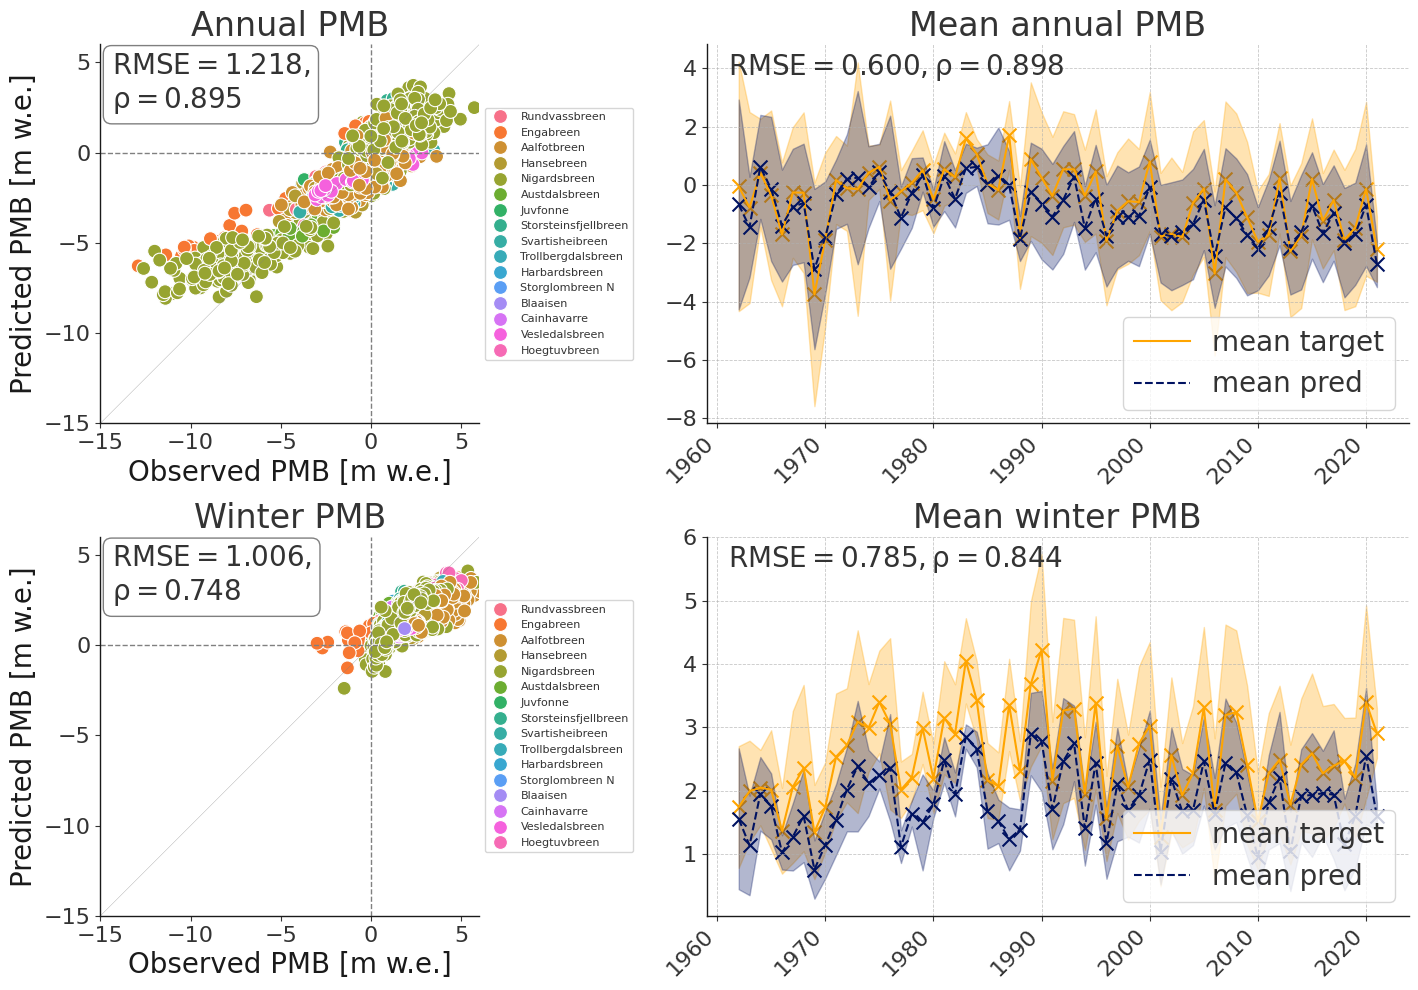

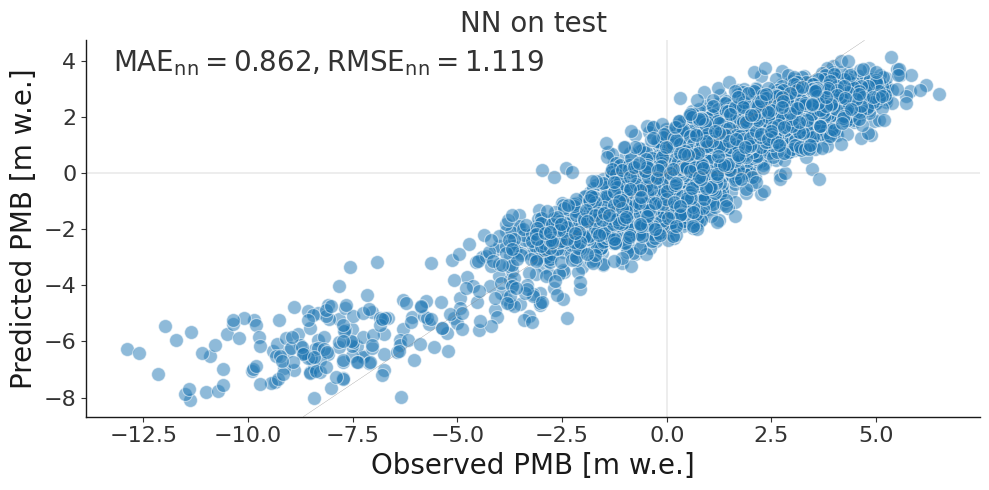

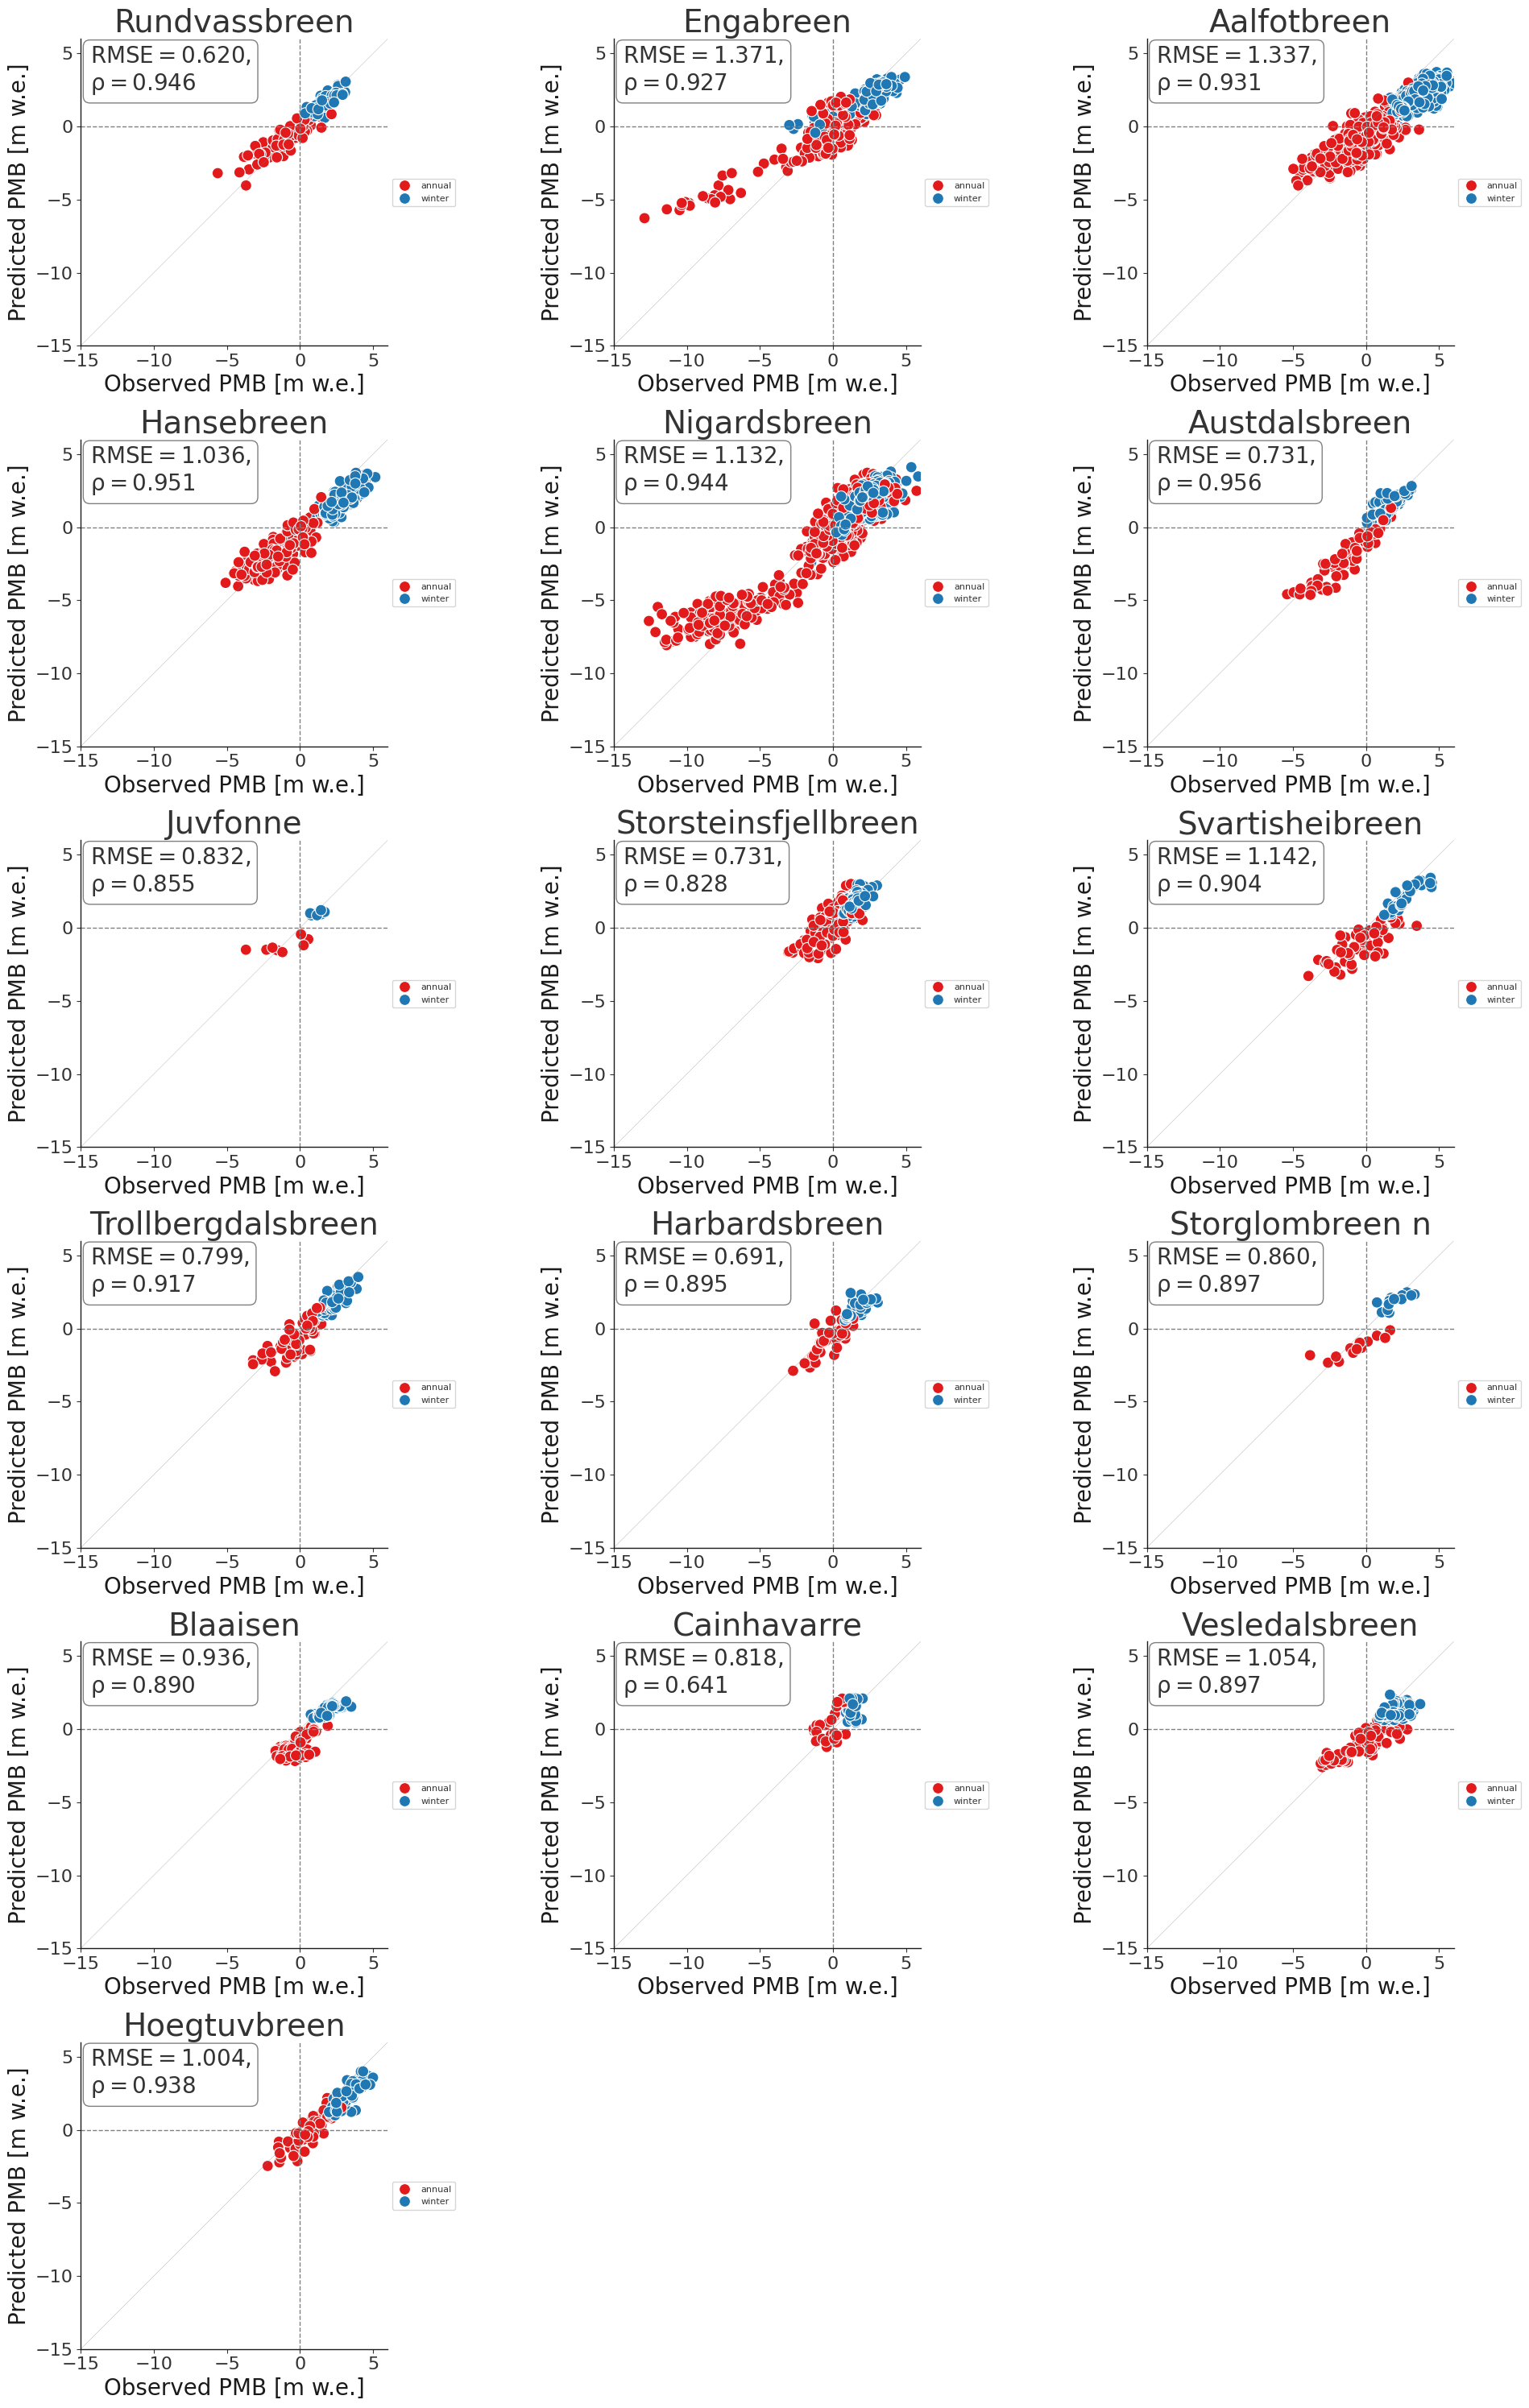

In [ ]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))